In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pinocchio as pin
from embedding import Embedding
from forward_kinematics import ForwardKinematic
from dynamical_system import DynamicalSystem
from utils.franka_parameters import joint_limits

In [2]:
fk = ForwardKinematic(urdf_file='franka_description/urdf/panda_no_gripper.urdf')
config_dim = fk.model.nq

K = 1 * np.eye(config_dim)
D = 1.5*np.eye(config_dim)

config_attractor = pin.randomConfiguration(fk.model)
print(f'attractor : {config_attractor}')

x = np.array([[-0.5], [0.], [2.]])[np.newaxis, :]

e = Embedding(dimension=config_dim, x=x.repeat(1, 0), fk=fk)

ds = DynamicalSystem(stiffness=K, dissipation=D, attractor=config_attractor, embedding=e, dt=0.01)

attractor : [-0.13413041  0.47233771 -0.80239598 -1.4838798   2.68362164  3.49465624
  0.80534054]


In [3]:
lower_bound = np.array([limit['lower'] for limit in joint_limits])
upper_bound = np.array([limit['upper'] for limit in joint_limits])

# config_start = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
config_start = pin.neutral(fk.model)
initial_speed = np.zeros_like(config_start)
q = config_start
dq = initial_speed
_ = fk(q, dq, derivation_order=0)

In [4]:
def plot_3d_ellipsoid_from_covariance(covariance_matrix, center=[0, 0, 0], ax=None):
    # From chatgpt
    """
    Plot a 3D ellipsoid from a covariance matrix.

    Args:
    covariance_matrix (array-like): Covariance matrix of shape (3, 3).
    center (array-like, optional): Center of the ellipsoid. Default is [0, 0, 0].
    ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.

    Returns:
    matplotlib.axes.Axes: Axes object containing the plot.
    """
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

    # Eigenvalue decomposition of covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort eigenvalues and corresponding eigenvectors
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Radii of the ellipsoid (square root of eigenvalues)
    radii = np.sqrt(eigenvalues)

    # Create sphere mesh
    u = np.linspace(0, 2 * np.pi, 10)
    v = np.linspace(0, np.pi, 10)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    # Apply rotation
    points = np.array([x.flatten(), y.flatten(), z.flatten()]).T
    rotated_points = np.dot(points, eigenvectors.T)
    x = np.reshape(rotated_points[:, 0], x.shape)
    y = np.reshape(rotated_points[:, 1], y.shape)
    z = np.reshape(rotated_points[:, 2], z.shape)

    # Plot ellipsoid
    ax.plot_surface(x + center[0], y + center[1], z + center[2], color='b', alpha=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    return ax

def visualize_robot(fk: ForwardKinematic, obstacle: np.ndarray = None):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(*(fk.mus[:, i] for i in range(3)))
    for i in range(fk.sigmas.shape[0]):
        plot_3d_ellipsoid_from_covariance(fk.sigmas[i], center=fk.mus[i], ax=ax)
    if obstacle is not None:
        ax.scatter(x[:, 0], x[:, 1], x[:, 2], c='black', s=100)
    ax.set_xlim([-2.1, 2.1])
    ax.set_ylim([-0.1, 2.1])
    ax.set_zlim([-0.1, 1.3])
    ax.axis('equal')
    return ax


In [5]:
fk.mus[1]

array([-0.00079332, -0.06655782,  0.37144671])

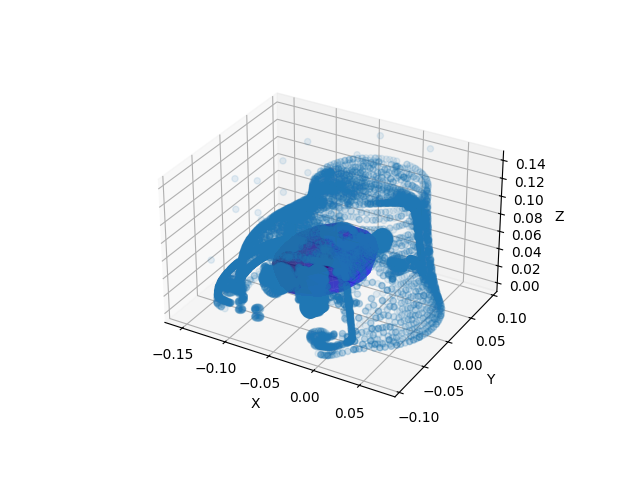

In [6]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
link_index = 0
pt = fk.links[link_index].points
mu = fk.links[link_index].means[np.newaxis, :]
cv = fk.links[link_index].covs[0]
ax.scatter(pt[:, 0], pt[:, 1], pt[:, 2], alpha=0.1)
ax.scatter(mu[:, 0], mu[:, 1], mu[:, 2], c='red', s=100)
plot_3d_ellipsoid_from_covariance(covariance_matrix=cv, center=mu.squeeze(), ax=ax)
ax.set_aspect('equal')
plt.show()

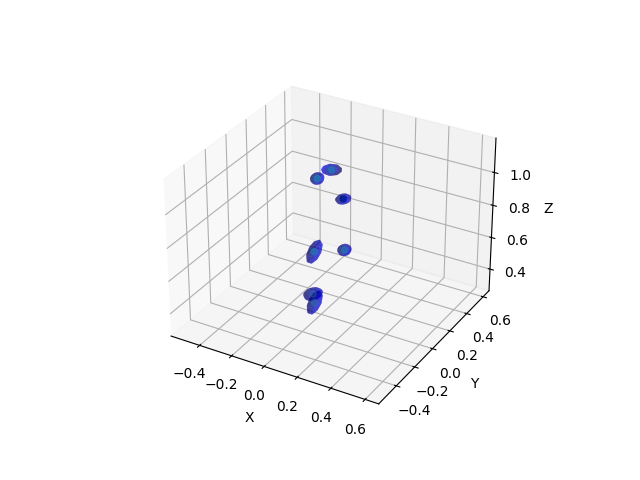

In [7]:
%matplotlib widget
visualize_robot(fk=fk, obstacle=None)
plt.show()

In [3]:
joints = list(filter(lambda frame: 'panda_joint' in frame.name, fk.model.frames))
links = list(filter(lambda frame: 'panda_link' in frame.name, fk.model.frames))

joint_ids = [fk.model.getFrameId(frame.name) for frame in joints]
links_ids = [fk.model.getFrameId(frame.name) for frame in links]

In [4]:
[frame.name for frame in joints]

['panda_joint1',
 'panda_joint2',
 'panda_joint3',
 'panda_joint4',
 'panda_joint5',
 'panda_joint6',
 'panda_joint7']

In [5]:
lower_bound = np.array([limit['lower'] for limit in joint_limits])
upper_bound = np.array([limit['upper'] for limit in joint_limits])

# config_start = pin.randomConfiguration(fk.model, lower_bound, upper_bound)
config_start = pin.neutral(fk.model)
initial_speed = np.zeros_like(config_start)
q = config_start
dq = initial_speed
_ = fk(q, dq, derivation_order=0)

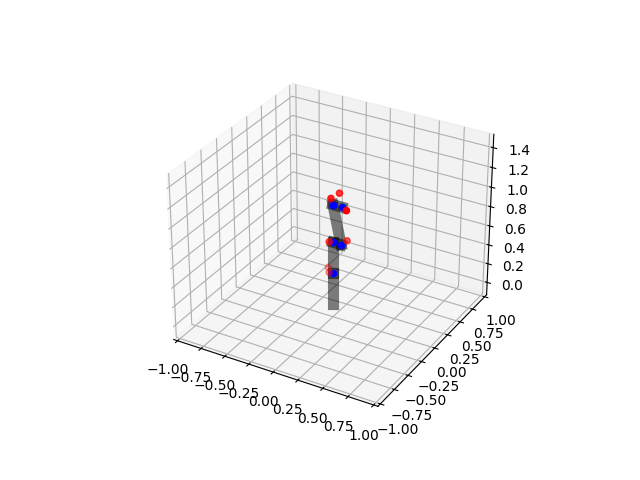

In [11]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-0.1, 1.5])
ax.set_aspect('equal')


root = fk.data.oMf[fk.model.getFrameId('root_joint')].translation
joint_position = fk.data.oMf[joint_ids[0]].translation
ax.plot([root[0], joint_position[0]], [root[1], joint_position[1]], [root[2], joint_position[2]], 'k-', linewidth=8, alpha=0.5)  # Link
ax.scatter(*joint_position, label=fk.model.frames[joint_ids[0]].name)
for i, joint_id in enumerate(joint_ids[1:]):
    # plotting the joints and the links
    p_joint_position = fk.data.oMf[joint_ids[i]].translation
    joint_position = fk.data.oMf[joint_id].translation
    ax.plot([p_joint_position[0], joint_position[0]], [p_joint_position[1], joint_position[1]], [p_joint_position[2], joint_position[2]], 'k-', linewidth=8, alpha=0.5)  # Link
    ax.scatter(*joint_position, c='blue')
    # plotting the centroids of the gmms
ax.scatter(fk.mus[:, 0], fk.mus[:, 1], fk.mus[:, 2], c='red')


plt.show()

In [5]:
[print(fk.data.oMf[link_id].rotation, link.name) for link_id, link in zip(links_ids, links)]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link0
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link1
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link2
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link3
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link4
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link5
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link6
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] panda_link7


[None, None, None, None, None, None, None, None]